#Install and Import Library

In [2]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import keras

#Get Data

In [6]:
def parse_data_from_file(filename):
  # Load the file, skipping the first three rows to remove unnecessary headers
  data = pd.read_csv(filename, skiprows=[1,2])

  # Rename price column to date
  data.rename(columns={'Price': 'Date'}, inplace=True)

  # Convert the 'Date' column to datetime format
  data['Date'] = pd.to_datetime(data['Date'])

  # Set 'Date' as the index
  data.set_index('Date', inplace=True)

  # Select only the 'Adj Close' column for forecasting
  data = data[['Adj Close']]

  data.head()

  dates = data.index.tolist()
  adj_closes = data['Adj Close'].tolist()

  return np.array(dates), np.array(adj_closes)

In [7]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [8]:
DATA_PATH = './usd.csv'

In [ ]:
data = yf.download("IDR=X", interval="1wk", start="2001-01-01", end="2024-12-01")
data.to_csv(DATA_PATH)

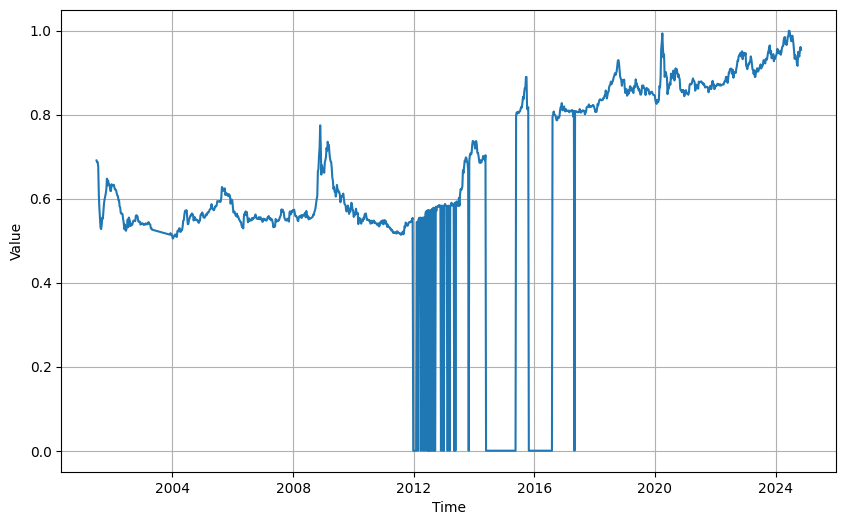

In [9]:
TIME, SERIES = parse_data_from_file(DATA_PATH)

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the series data
SERIES = scaler.fit_transform(SERIES.reshape(-1, 1)).flatten()

# Plot the series!
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)

#Global Variable

In [109]:
# Save all global variables
SPLIT_TRAIN = int(len(SERIES) * 0.8)
SPLIT_VALID = int(len(SERIES) * 0.95)
WINDOW_SIZE = 4
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

#Train Data

In [110]:
#Split data train and validation
def train_val_split(time, series):
    """ Splits time series into train and validations sets"""
    time_train = time[:SPLIT_TRAIN]
    series_train = series[:SPLIT_TRAIN]

    time_valid = time[SPLIT_TRAIN:SPLIT_VALID]
    series_valid = series[SPLIT_TRAIN:SPLIT_VALID]

    time_test = time[SPLIT_VALID:]
    series_test = series[SPLIT_VALID:]

    return time_train, series_train, time_valid, series_valid, time_test, series_test

In [111]:
time_train, series_train, time_valid, series_valid, time_test, series_test = train_val_split(TIME, SERIES)

In [112]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

In [113]:
train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)
valid_dataset = windowed_dataset(series_valid, window_size=WINDOW_SIZE)
test_dataset = windowed_dataset(series_test, window_size=WINDOW_SIZE)

#Defining the model architecture


In [13]:
# def create_uncompiled_model():
#     """Define uncompiled model

#     Returns:
#         tf.keras.Model: uncompiled model
#     """

#     model = tf.keras.models.Sequential([
#         tf.keras.Input(shape=(None, 1)),
#         tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='causal'),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128)),
#         tf.keras.layers.Dense(1),
#         tf.keras.layers.Lambda(lambda x: x * 200)
#     ])

#     return model

In [287]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Lambda, Conv1D, MaxPooling1D, Bidirectional, Input

In [405]:
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """

    # model = tf.keras.models.Sequential([
    #     tf.keras.Input(shape=(None, 1)),
    #     tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'),
    #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
    #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
    #     tf.keras.layers.Dense(1),
    #     tf.keras.layers.Lambda(lambda x: x * 200)
    # ])
    # ===== 2 =====
    # model = tf.keras.models.Sequential([
    #     Input(shape=(WINDOW_SIZE, 1)),
    #     Conv1D(filters=256, kernel_size=5, activation='relu', padding='causal'),
    #     Bidirectional(LSTM(512, return_sequences=True)),
    #     Bidirectional(LSTM(256, return_sequences=True)),
    #     LSTM(128),
    #     Dense(20, activation='relu'),
    #     Dense(1),
    #     Lambda(lambda x: x * 700)
    # ])

    model = tf.keras.models.Sequential([
        Input(shape=(WINDOW_SIZE, 1)),
        Conv1D(filters=256, kernel_size=5, activation='relu', padding='causal'),
        Bidirectional(LSTM(512, return_sequences=True)),
        Bidirectional(LSTM(256, return_sequences=True)),
        LSTM(128),
        Dense(20, activation='relu'),
        Dense(1),
        Lambda(lambda x: x * 700)
    ])

    return model

In [406]:
uncompiled_model = create_uncompiled_model()

In [407]:
example_batch = train_dataset.take(1)

In [408]:
try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")


Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (64, 1)


In [409]:
uncompiled_model.summary()

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_51 (Conv1D)          (None, 4, 256)            1536      
                                                                 
 bidirectional_114 (Bidirect  (None, 4, 1024)          3149824   
 ional)                                                          
                                                                 
 bidirectional_115 (Bidirect  (None, 4, 1024)          6295552   
 ional)                                                          
                                                                 
 bidirectional_116 (Bidirect  (None, 4, 512)           2623488   
 ional)                                                          
                                                                 
 lstm_212 (LSTM)             (None, 128)               328192    
                                                     

#Adjust Learning Rate

#Create Model

In [410]:
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """

    model = create_uncompiled_model()

    model.compile(loss='huber',
                  optimizer='adam',
                  metrics=["mae", "mse"])

    return model

In [411]:
# Instantiate and train the model with early stopping
model = create_model()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
history = model.fit(train_dataset, validation_data = valid_dataset, epochs=50, callbacks=[early_stopping, reduce_lr])

# Output the model summary and training history (loss per epoch)


Epoch 1/50
15/15 [==============================] - 9s 155ms/step - loss: 4.6026 - mae: 5.0030 - mse: 96.2723 - val_loss: 0.0385 - val_mae: 0.2773 - val_mse: 0.0771 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 1s 37ms/step - loss: 0.0369 - mae: 0.2310 - mse: 0.0739 - val_loss: 9.3436e-04 - val_mae: 0.0411 - val_mse: 0.0019 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 1s 34ms/step - loss: 0.0160 - mae: 0.1395 - mse: 0.0319 - val_loss: 4.8850e-04 - val_mae: 0.0290 - val_mse: 9.7700e-04 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 1s 30ms/step - loss: 0.0115 - mae: 0.0992 - mse: 0.0230 - val_loss: 5.4748e-04 - val_mae: 0.0310 - val_mse: 0.0011 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 1s 34ms/step - loss: 0.0078 - mae: 0.0681 - mse: 0.0156 - val_loss: 3.7775e-04 - val_mae: 0.0253 - val_mse: 7.5551e-04 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 1s 31ms/step - loss: 0.0074 - mae: 0.0536 

In [412]:
model.summary(), history.history['loss'][:10]

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_52 (Conv1D)          (None, 4, 256)            1536      
                                                                 
 bidirectional_117 (Bidirect  (None, 4, 1024)          3149824   
 ional)                                                          
                                                                 
 bidirectional_118 (Bidirect  (None, 4, 1024)          6295552   
 ional)                                                          
                                                                 
 bidirectional_119 (Bidirect  (None, 4, 512)           2623488   
 ional)                                                          
                                                                 
 lstm_216 (LSTM)             (None, 128)               328192    
                                                     

(None,
 [4.6025567054748535,
  0.03692921623587608,
  0.015973951667547226,
  0.01151654776185751,
  0.00778120756149292,
  0.007432926446199417,
  0.007975147105753422,
  0.006988739129155874,
  0.007324733305722475,
  0.007422805298119783])

In [413]:
# Plot the training loss for each epoch
loss = history.history['loss']
# loss = best_validation_loss
epochs = range(len(loss))

In [414]:
# Evaluasi akhir model pada test set
train_loss = model.evaluate(train_dataset)
print("Train Loss:", train_loss)

# Evaluasi akhir model pada test set
valid_loss = model.evaluate(valid_dataset)
print("Valid Loss:", valid_loss)

# Evaluasi akhir model pada test set
test_loss = model.evaluate(test_dataset)
print("Test Loss:", test_loss)

15/15 [==============================] - 0s 21ms/step - loss: 0.0073 - mae: 0.0581 - mse: 0.0145
Train Loss: [0.007251830771565437, 0.058073826134204865, 0.014503661543130875]
3/3 [==============================] - 0s 28ms/step - loss: 6.2981e-05 - mae: 0.0085 - mse: 1.2596e-04
Valid Loss: [6.29808782832697e-05, 0.008475693874061108, 0.0001259617565665394]
1/1 [==============================] - 0s 67ms/step - loss: 9.1068e-05 - mae: 0.0112 - mse: 1.8214e-04
Test Loss: [9.106820652959868e-05, 0.01115062739700079, 0.00018213641305919737]


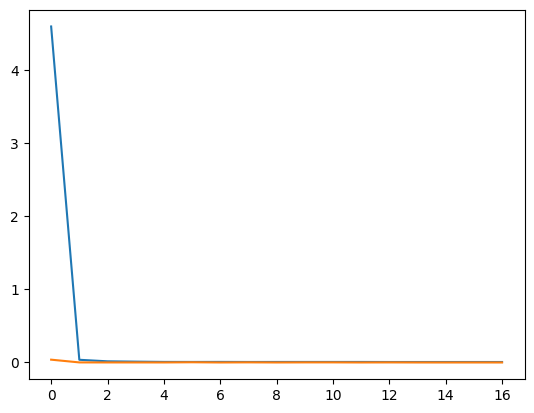

In [415]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

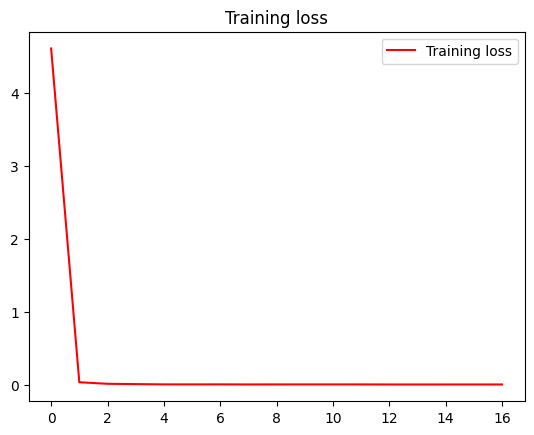

In [416]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

#Evaluate Forecast & Model Forecast

In [417]:
"""## Evaluating the forecast"""
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

In [418]:
"""## Faster Model Forecasts"""
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast



#TESTING AND PLOTTING USING BOTH VALID AND TEST SET (IF AVAILABLE)


6/6 [==============================] - 2s 38ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


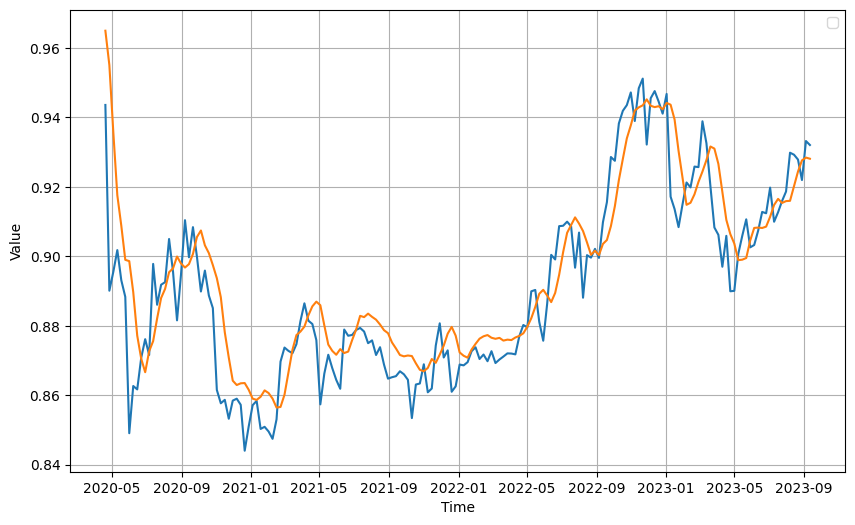

In [419]:
# Gunakan hanya data untuk validation set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_valid = model_forecast(model, SERIES[SPLIT_TRAIN - WINDOW_SIZE:SPLIT_VALID], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_valid sama dengan time_valid
rnn_forecast_valid = rnn_forecast_valid[:len(time_valid)]

# Plot the validation forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast_valid)
plt.legend()
plt.show()

2/2 [==============================] - 0s 37ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


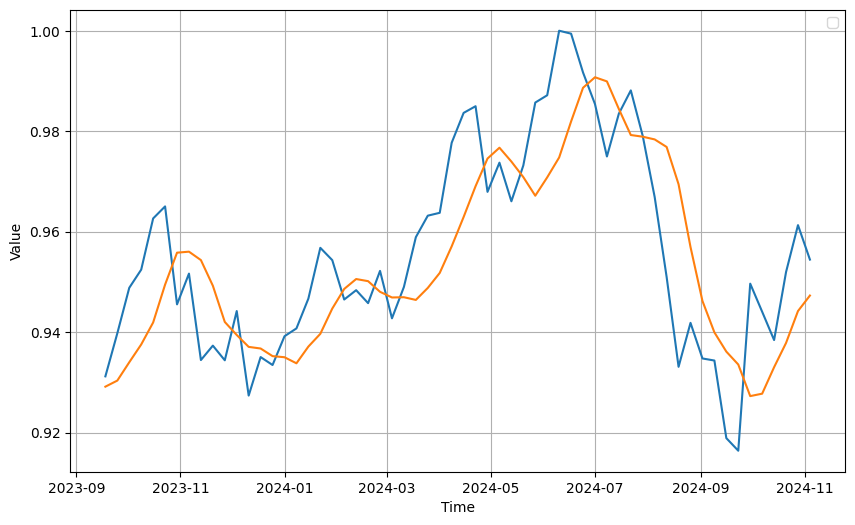

In [420]:
# Gunakan hanya data untuk validation set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_test = model_forecast(model, SERIES[SPLIT_VALID - WINDOW_SIZE:], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_valid sama dengan time_valid
rnn_forecast_test = rnn_forecast_test[:len(time_test)]

# Plot the validation forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, rnn_forecast_test)
plt.legend()
plt.show()

8/8 [==============================] - 0s 34ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


238
238


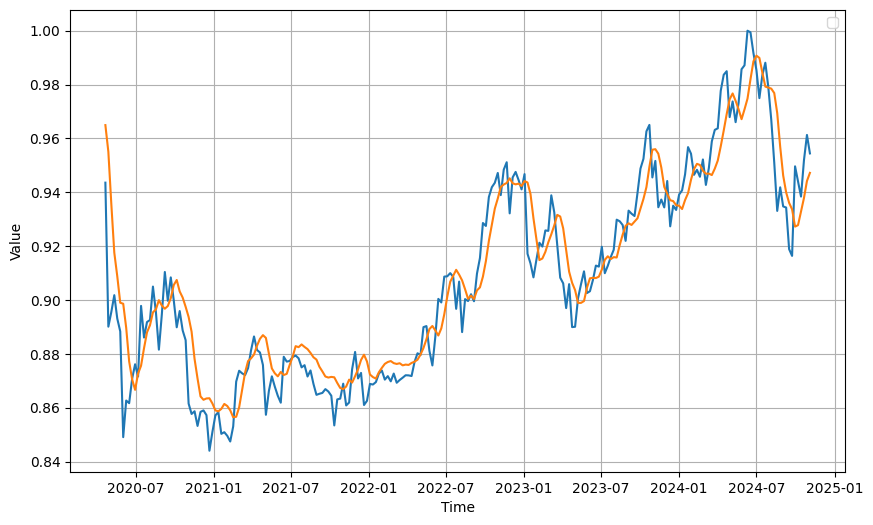

In [421]:
# Gunakan hanya data untuk test set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_combined = model_forecast(model, SERIES[SPLIT_TRAIN - WINDOW_SIZE:SPLIT_VALID + len(series_test)], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_test sama dengan time_test
rnn_forecast_combined = rnn_forecast_combined[:len(time_valid) + len(time_test)]

print(np.concatenate([time_valid,time_test]).size)
print(rnn_forecast_combined.size)

# Plot the test forecast
plt.figure(figsize=(10, 6))
plot_series(np.concatenate([time_valid,time_test]), np.concatenate([series_valid, series_test]))
plot_series(np.concatenate([time_valid,time_test]), rnn_forecast_combined)
plt.legend()
plt.show()


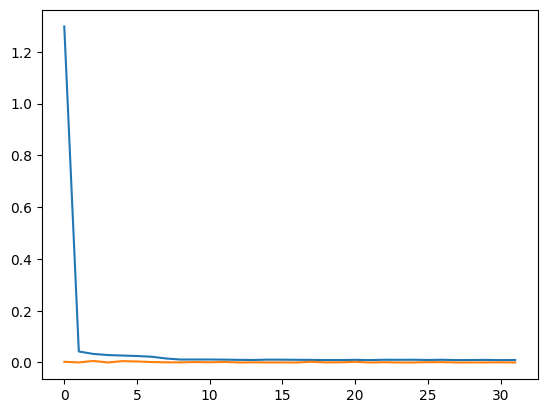

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

#MAE & MSE EVALUATION

In [35]:
# mse, mae = compute_metrics(series_valid, rnn_forecast)

# print(f"mse: {mse:.5f}, mae: {mae:.5f} for forecast")

In [335]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def walking_validation(data, window_size, stride, validation_size, model_func):
    """
    Implements walking validation for time series data

    Parameters:
    data: array-like, full time series data
    window_size: int, size of the training window
    stride: int, number of steps to move forward
    validation_size: int, size of validation set
    model_func: function that returns compiled model

    Returns:
    list of validation scores
    """
    validation_scores = []

    # Initialize scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    for i in range(0, len(data) - window_size - validation_size, stride):
        # Get training and validation windows
        train_data = data[i:i + window_size]
        val_data = data[i + window_size:i + window_size + validation_size]

        # Scale the data
        train_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
        val_scaled = scaler.transform(val_data.reshape(-1, 1)).flatten()

        # Create sequences
        X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)
        X_val, y_val = create_sequences(val_scaled, WINDOW_SIZE)

        # Create and train model
        model = model_func()

        # Convert to tensorflow dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
            .batch(BATCH_SIZE).prefetch(1)
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))\
            .batch(BATCH_SIZE).prefetch(1)

        # Train model
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=50,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
            ],
            verbose=0
        )

        # Get validation score
        val_score = model.evaluate(val_dataset, verbose=0)[0]
        validation_scores.append(val_score)

        print(f"Window {i}: Validation Score = {val_score:.4f}")

    return validation_scores

# Parameter untuk validasi long-term forecast
window_size = 260   # 5 tahun data mingguan (52 * 5)
stride = 52         # 1 tahun
validation_size = 156  # 3 tahun validasi

def model_func():
    return create_model()  # Your existing model creation function

# Run walking validation
validation_scores = walking_validation(
    SERIES,
    window_size,
    stride,
    validation_size,
    model_func
)

# Plot validation scores
plt.figure(figsize=(12, 6))
plt.plot(validation_scores)
plt.title('Walking Validation Scores')
plt.xlabel('Validation Window')
plt.ylabel('Loss Score')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

#Forecast The Future Series

1/1 [==============================] - 0s 27ms/step


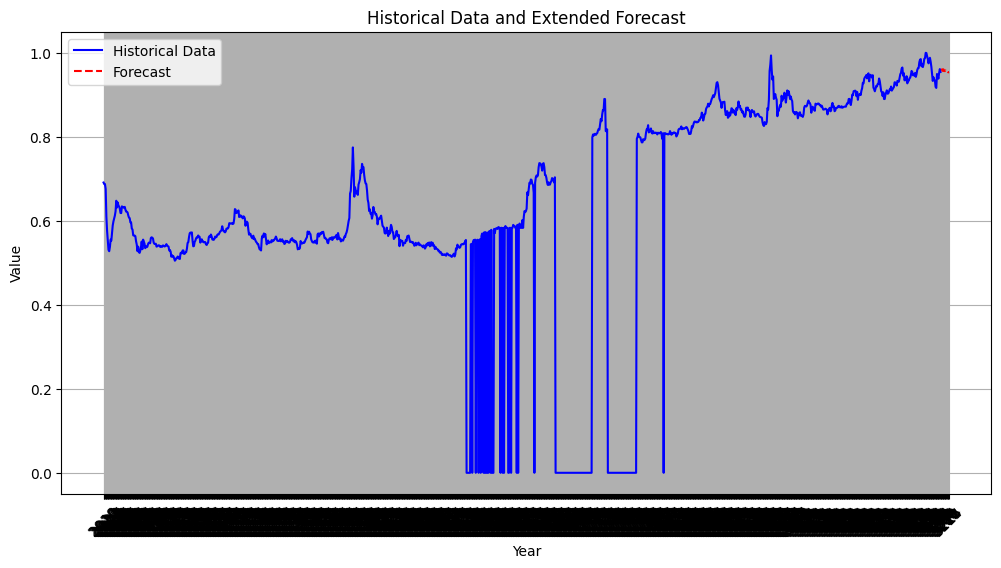

In [336]:
import numpy as np
import matplotlib.pyplot as plt

def extended_forecast(model, series, window_size, forecast_steps):
    """
    Generates a forecast using your trained model up to a specified number of future steps.
    """
    # Initialize forecast results with the original series to begin prediction
    forecast = list(series[-window_size:])  # Start from the last known window

    for _ in range(forecast_steps):
        # Convert forecast list to tensor
        input_series = np.array(forecast[-window_size:]).reshape(1, -1)  # Shape (1, window_size)

        # Predict the next step
        next_step = model.predict(input_series)[0][0]  # Get the predicted value

        # Append the next step to the forecast
        forecast.append(next_step)

    # Return only the future forecasted steps
    return np.array(forecast[-forecast_steps:])

def plot_extended_forecast(model, series, window_size, forecast_steps, start_year):
    """
    Generates a forecast using your trained model up to a specified number of future steps
    and plots it along with the original series.
    """
    # Generate extended forecast
    forecast = extended_forecast(model, series, window_size, forecast_steps)

    # Define years for plotting
    historical_years = np.arange(start_year, start_year + len(series))
    future_years = np.arange(start_year + len(series), start_year + len(series) + forecast_steps)

    # Plot historical data and forecast
    plt.figure(figsize=(12, 6))
    plt.plot(historical_years, series, label="Historical Data", color="blue")
    plt.plot(future_years, forecast, label="Forecast", color="red", linestyle="--")

    # Adjust x-axis ticks for years
    tick_years = np.concatenate((historical_years, future_years))
    plt.xticks(tick_years, [str(year) for year in tick_years], rotation=45)

    # Add labels and legend
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title("Historical Data and Extended Forecast")
    plt.legend()
    plt.grid(True)
    plt.show()

# Contoh pemanggilan fungsi plot dengan input yang disesuaikan
start_year = 2018  # Tahun pertama data historis
forecast_steps = 12  # Jumlah tahun yang ingin diprediksi (2025-2030)

plot_extended_forecast(model, SERIES, WINDOW_SIZE, forecast_steps, start_year)

In [212]:
predicted_values = extended_forecast(model, SERIES, WINDOW_SIZE, forecast_steps=6)
print(predicted_values)

1/1 [==============================] - 0s 24ms/step
[0.9534848  0.9517665  0.9497207  0.94800216 0.94623154 0.9445125 ]


# Save and Load Model

In [6]:
new_model = tf.keras.models.load_model('./model/model_saham.h5')

In [7]:
tf.keras.models.save_model(new_model, './model/my_model.keras')

In [35]:
# Gunakan hanya data untuk validation set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_valid = model_forecast(new_model, SERIES[SPLIT_TRAIN - WINDOW_SIZE:SPLIT_VALID], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_valid sama dengan time_valid
rnn_forecast_valid = rnn_forecast_valid[:len(time_valid)]

# Plot the validation forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast_valid)
plt.legend()
plt.show()


NameError: name 'new_model' is not defined

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


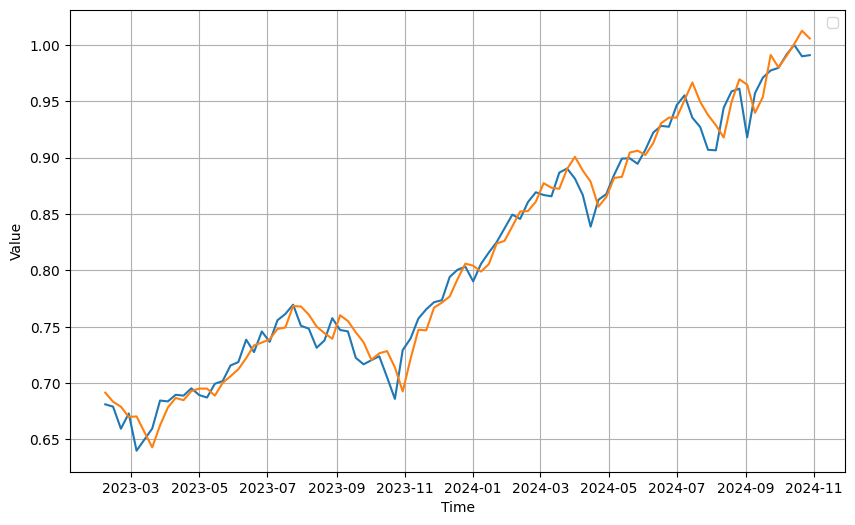

In [60]:
# Gunakan hanya data untuk validation set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_test = model_forecast(model, SERIES[SPLIT_VALID - WINDOW_SIZE:], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_valid sama dengan time_valid
rnn_forecast_test = rnn_forecast_test[:len(time_test)]

# Plot the validation forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, rnn_forecast_test)
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


364
364


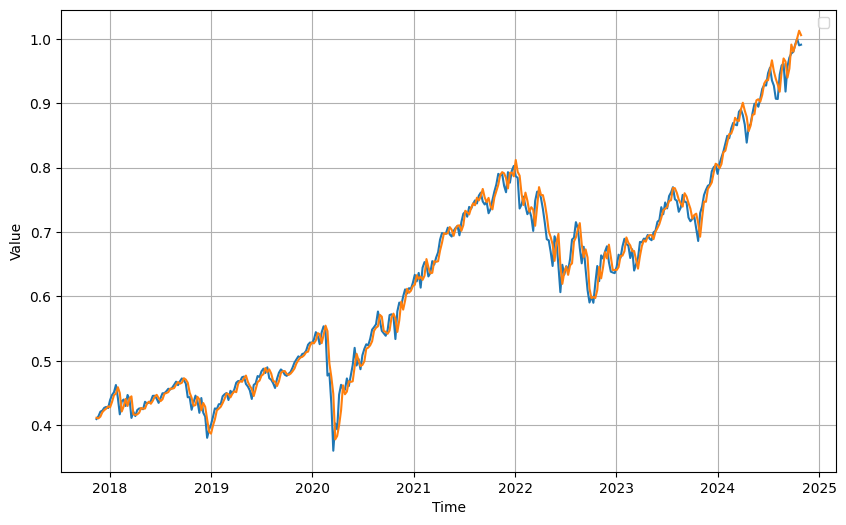

In [61]:
# Gunakan hanya data untuk test set, ditambah WINDOW_SIZE sebelumnya
rnn_forecast_combined = model_forecast(model, SERIES[SPLIT_TRAIN - WINDOW_SIZE:SPLIT_VALID + len(series_test)], WINDOW_SIZE).squeeze()

# Pastikan panjang rnn_forecast_test sama dengan time_test
rnn_forecast_combined = rnn_forecast_combined[:len(time_valid) + len(time_test)]

print(np.concatenate([time_valid,time_test]).size)
print(rnn_forecast_combined.size)

# Plot the test forecast
plt.figure(figsize=(10, 6))
plot_series(np.concatenate([time_valid,time_test]), np.concatenate([series_valid, series_test]))
plot_series(np.concatenate([time_valid,time_test]), rnn_forecast_combined)
plt.legend()
plt.show()

In [ ]:
config = model.get_config()
print(config)